In [1]:
import sys
sys.path.insert(0, '../tools')

%load_ext prov_magics
import provn
import prov_dictionary

# PROV Dictionary

In this document we map simple script constructs to PROV-Dictionary

## Names, literals, and constants

`entities` represent variables names, literals (e.g., "a", 1, True), and constants (e.g., `...`)
```python
1     # literal
"a"   # literal
b"a"  # literal
True  # literal
int   # names
...   # constant
```

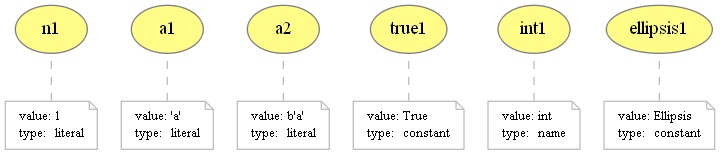

In [2]:
%%provn -o ../prov_dictionary/names.png
entity(n1, [value="1", type="literal"])
entity(a1, [value="'a'", type="literal"])
entity(a2, [value="b'a'", type="literal"])
entity(true1, [prov:value="True", type="constant"])
entity(int1, [prov:value="int", type="name"])
entity(ellipsis1, [prov:value="Ellipsis", type="constant"])

## Assignment

We represent an assignment by an `activity` that uses the `entities` on the right side to generate an `entity` on the left side. 

An assignment creates a new entity for the name on the left side even when the name already exists.

```python
m = 10000
```

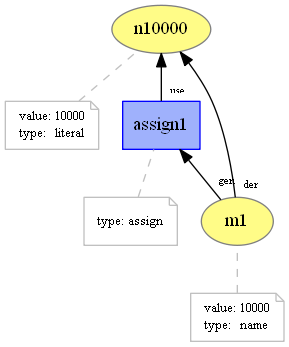

In [3]:
%%provn -o ../prov_dictionary/assign.png
entity(n10000, [value="10000", type="literal"])
entity(m1, [value="10000", type="name"])

activity(assign1, [type="assign"])
used(u1; assign1, n10000, -)
wasGeneratedBy(g1; m1, assign1, -)
wasDerivedFrom(m1, n10000, assign1, g1, u1)

## Operation

Similar to assigments, we also use `activities` to map operations. However, instead of producing an `entity` for a variable name, it produces an `entity` for the evaluation result.

```python
m + 1
```

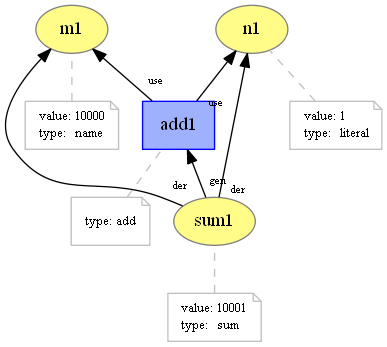

In [4]:
%%provn -o ../prov_dictionary/operation.png
entity(m1, [value="10000", type="name"])
entity(n1, [value="1", type="literal"])
entity(sum1, [value="10001", type="sum"])

activity(add1, [type="add"])
used(u2; add1, m1, -)
used(u3; add1, n1, -)
wasGeneratedBy(g2; sum1, add1, -)
wasDerivedFrom(sum1, m1, add1, g2, u2)
wasDerivedFrom(sum1, n1, add1, g3, u3)

## List definition

A list is represented by a PROV-Dictionary that has the list indexes as keys.

According to the [PROV-Dictionary documentation](https://www.w3.org/TR/prov-dictionary/), a complete dictionary must be able to be traced back to an empty dictionary. Since we have the complete list definition, we always define a list entity by creating an empty dictionary. Then, we use the `derivedByInsertionFrom` relationship to insert its elements.

The provenance of a `Floyd-Warshall` execution should indicate the position of accessed elements in the result matrix (list of lists) to allow the querying of the shortest-path between two nodes. However, the PROV-Dictionary extension does not indicate accesses to positions (note below that an `entity` may repeat in multiple positions). Thus, to allow this query, we create an extra `entity` for every position in the list and we use an `activity` to derive these `entities` from the actual `entities` that compose the dictionary.

For simplicity, in the case of the definition of matrices, we use a single `activity` to represent all the derivations, instead of an `activity` for each row.

```python
[m, m + 1, m]
```

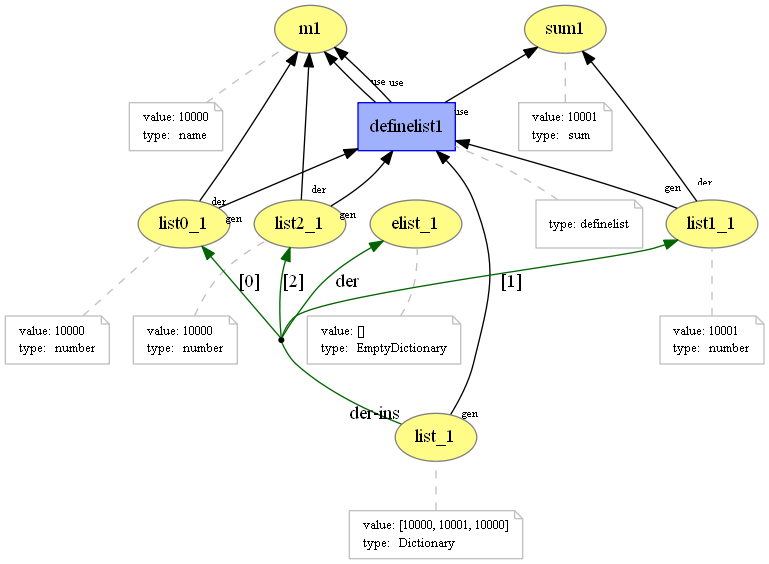

In [5]:
%%provn -o ../prov_dictionary/list.png
entity(m1, [value="10000", type="name"])
entity(sum1, [value="10001", type="sum"])

entity(elist_1, [value="[]", type="EmptyDictionary"])
entity(list_1, [value="[10000, 10001, 10000]", type="Dictionary"])
entity(list0_1, [value="10000", type="number"])
entity(list1_1, [value="10001", type="number"])
entity(list2_1, [value="10000", type="number"])
derivedByInsertionFrom(
    list_1, elist_1,
    {("0", list0_1), ("1", list1_1), ("2", list2_1)}
)

activity(definelist1, [type="definelist"])
used(u4; definelist1, m1, -)
wasGeneratedBy(g4; list0_1, definelist1, -)
wasDerivedFrom(list0_1, m1, definelist1, g4, u4)
used(u5; definelist1, sum1, -)
wasGeneratedBy(g5; list1_1, definelist1, -)
wasDerivedFrom(list1_1, sum1, definelist1, g5, u5)
used(u6; definelist1, m1, -)
wasGeneratedBy(g6; list2_1, definelist1, -)
wasDerivedFrom(list2_1, m1, definelist1, g6, u6)
wasGeneratedBy(list_1, definelist1, -)

## Assign list definition

When we assign a list definition to a variable, the variable is also a dictionary. The PROV-Dictionary extension does not have a derivation rule to indicate that a dictionary is the same as the other. Thus, we must create a new dictionary that have the same keys as the existing one.

Note that we do not create new entities for the dictionary members. We just reuse the existing ones. Note however that we create an empty dictionary and derive the new one from it.

```python
d = [m, m + 1, m]
```

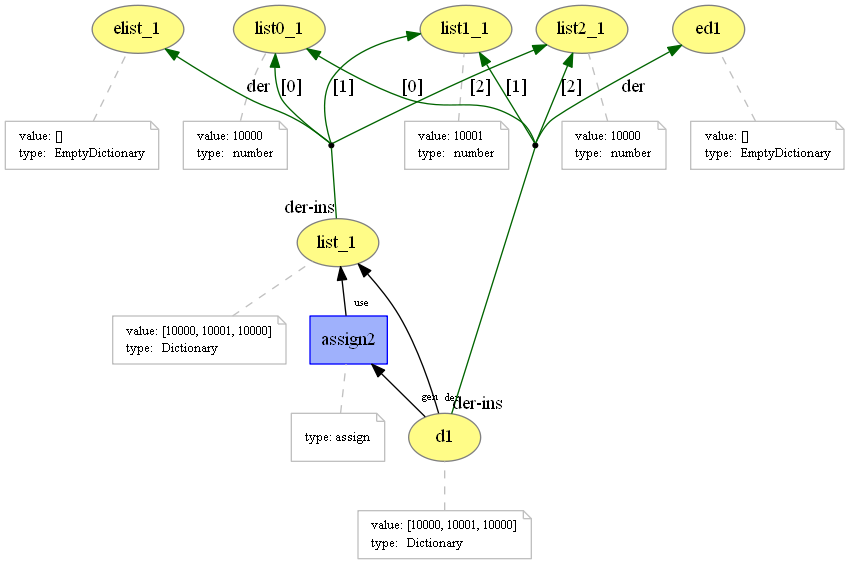

In [6]:
%%provn -o ../prov_dictionary/list_assign.png
// old entities from previous figure
entity(elist_1, [value="[]", type="EmptyDictionary"])
entity(list_1, [value="[10000, 10001, 10000]", type="Dictionary"])
entity(list0_1, [value="10000", type="number"])
entity(list1_1, [value="10001", type="number"])
entity(list2_1, [value="10000", type="number"])
derivedByInsertionFrom(
    list_1, elist_1,
    {("0", list0_1), ("1", list1_1), ("2", list2_1)}
)

// new entities
entity(ed1, [value="[]", type="EmptyDictionary"])
entity(d1, [value="[10000, 10001, 10000]", type="Dictionary"])
derivedByInsertionFrom(
    d1, ed1,
    {("0", list0_1), ("1", list1_1), ("2", list2_1)}
)

activity(assign2, [type="assign"])
used(u7; assign2, list_1, -)
wasGeneratedBy(g7; d1, assign2, -)
wasDerivedFrom(d1, list_1, assign2, g7, u7)

The same mapping is valid for assignments to names that represent dictionaries

```python
x = d
```

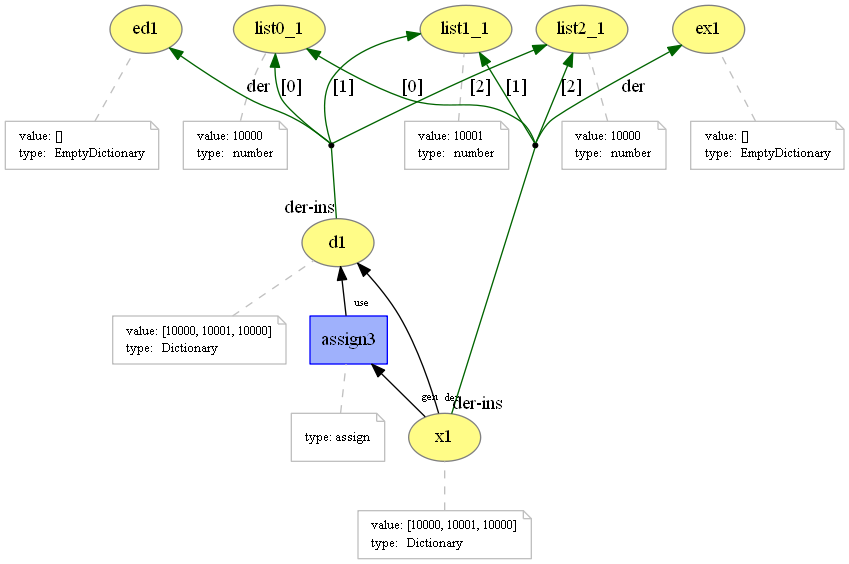

In [7]:
%%provn -o ../prov_dictionary/list_assign2.png
// old entities from previous figure
entity(ed1, [value="[]", type="EmptyDictionary"])
entity(d1, [value="[10000, 10001, 10000]", type="Dictionary"])
entity(list0_1, [value="10000", type="number"])
entity(list1_1, [value="10001", type="number"])
entity(list2_1, [value="10000", type="number"])
derivedByInsertionFrom(
    d1, ed1,
    {("0", list0_1), ("1", list1_1), ("2", list2_1)}
)

// new entities
entity(ex1, [value="[]", type="EmptyDictionary"])
entity(x1, [value="[10000, 10001, 10000]", type="Dictionary"])
derivedByInsertionFrom(
    x1, ex1,
    {("0", list0_1), ("1", list1_1), ("2", list2_1)}
)

activity(assign3, [type="assign"])
used(u8; assign3, d1, -)
wasGeneratedBy(g8; x1, assign3, -)
wasDerivedFrom(x1, d1, assign3, g8, u8)

## Function call

We map a function call as an `activity` that `uses` its parameters and `generates` an `entity` with its return. 

When we do not know the function call implementation, we cannot use `derivation` relationships

```python
len(d)
```

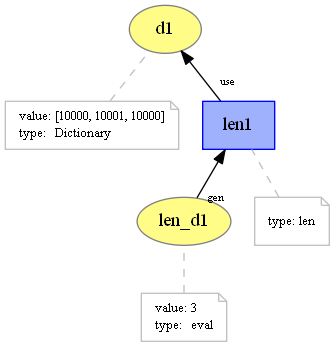

In [8]:
%%provn -o ../prov_dictionary/call.png
entity(d1, [value="[10000, 10001, 10000]", type="Dictionary"])
entity(len_d1, [value="3", type="eval"])

activity(len1, [type="len"])
used(len1, d1, -)
wasGeneratedBy(len_d1, len1, -)

## Access

We map an access as an `activity` that generates the accessed `entity`, by using the list `entity`, the list element, and the index, when it is explicitly used (for-each loops iterates over lists without explicit item `entities`). The generated `entity` derives from the list element.

```python
d[0]
```

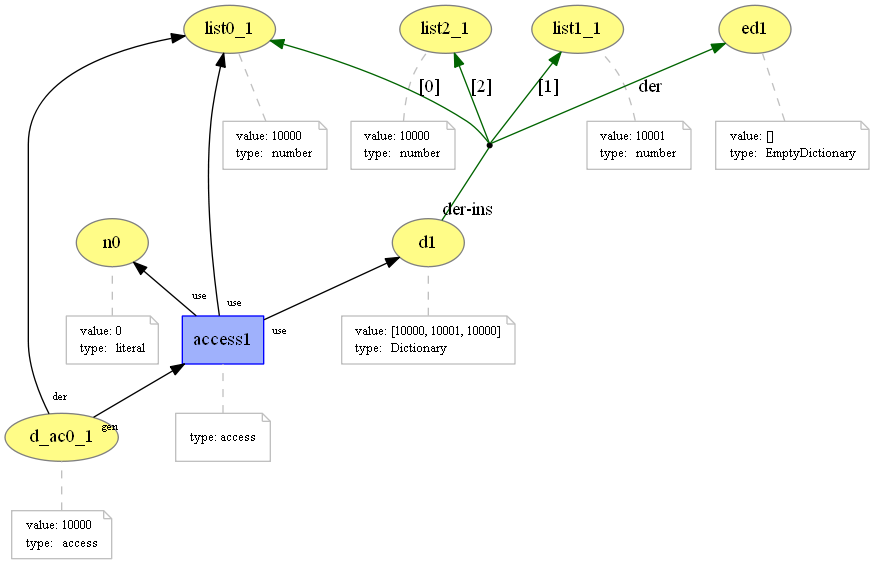

In [9]:
%%provn -o ../prov_dictionary/access.png
//previous
entity(list0_1, [value="10000", type="number"])
entity(list1_1, [value="10001", type="number"])
entity(list2_1, [value="10000", type="number"])
entity(ed1, [value="[]", type="EmptyDictionary"])
entity(d1, [value="[10000, 10001, 10000]", type="Dictionary"])
derivedByInsertionFrom(
    d1, ed1,
    {("0", list0_1), ("1", list1_1), ("2", list2_1)}
)


//access
entity(n0, [value="0", type="literal"])
entity(d_ac0_1, [value="10000", type="access"])

activity(access1, [type="access"])
used(access1, d1, -)
used(access1, n0, -)
used(u9; access1, list0_1, -)
wasGeneratedBy(g9; d_ac0_1, access1, -)
wasDerivedFrom(d_ac0_1, list0_1, access1, g9, u9)

## Part Assignment

A part assignment is similitar to an assignment, but it produces a dictionary derivation using `derivedByInsertionFrom`.

If there is more than one variable or data structure with a reference to the changed list, we must update all the lists.

The assignment `activity` uses all the changed `entities` and generates new versions of them. Additionally, it uses the right side of the assignment to derive an entity for the left side. 

```python
d[1] = 3
```

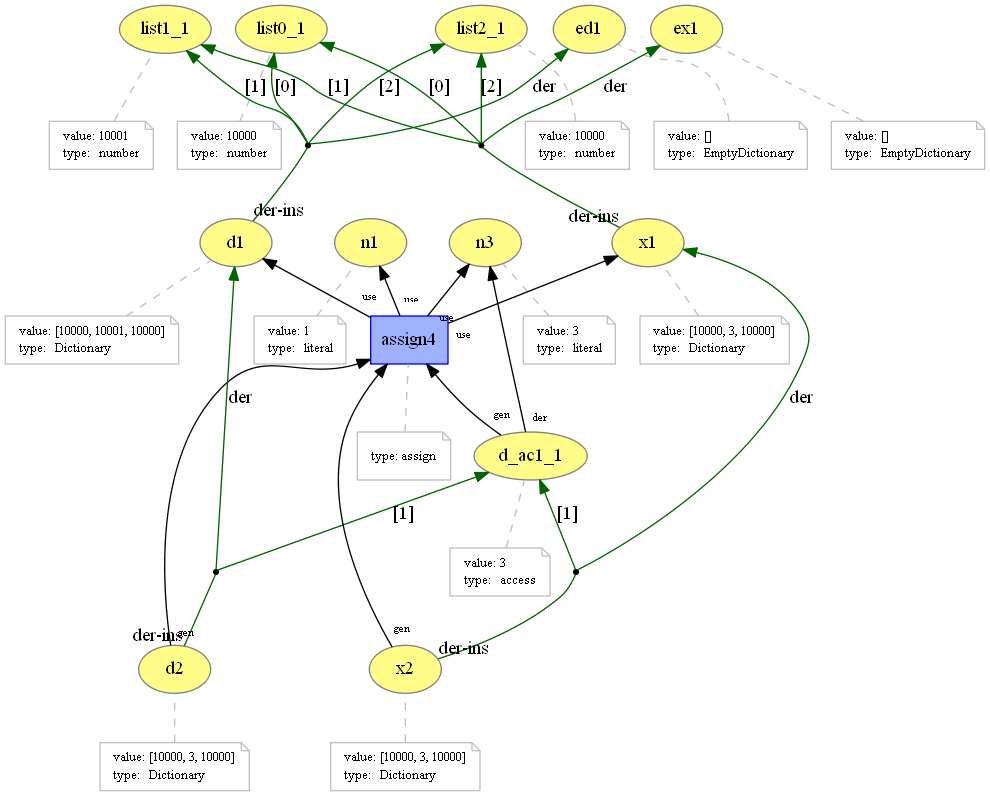

In [10]:
%%provn -o ../prov_dictionary/part_assign.png
//previous
entity(list0_1, [value="10000", type="number"])
entity(list1_1, [value="10001", type="number"])
entity(list2_1, [value="10000", type="number"])
entity(ed1, [value="[]", type="EmptyDictionary"])
entity(d1, [value="[10000, 10001, 10000]", type="Dictionary"])
derivedByInsertionFrom(
    d1, ed1,
    {("0", list0_1), ("1", list1_1), ("2", list2_1)}
)

entity(ex1, [value="[]", type="EmptyDictionary"])
entity(x1, [value="[10000, 3, 10000]", type="Dictionary"])
derivedByInsertionFrom(
    x1, ex1,
    {("0", list0_1), ("1", list1_1), ("2", list2_1)}
)

//part assign
entity(n1, [value="1", type="literal"])
entity(n3, [value="3", type="literal"])
entity(d_ac1_1, [value="3", type="access"])
entity(d2, [value="[10000, 3, 10000]", type="Dictionary"])
derivedByInsertionFrom(d2, d1, {("1", d_ac1_1)})
entity(x2, [value="[10000, 3, 10000]", type="Dictionary"])
derivedByInsertionFrom(x2, x1, {("1", d_ac1_1)})

activity(assign4, [type="assign"])
used(assign4, d1, -)
used(assign4, x1, -)
used(assign4, n1, -)
used(u10; assign4, n3, -)
wasGeneratedBy(g10; d_ac1_1, assign4, -)
wasGeneratedBy(d2, assign4, -)
wasGeneratedBy(x2, assign4, -)
wasDerivedFrom(d_ac1_1, n3, assign4, g10, u10)